# Challenge 3 - Short-term model

In [1]:
# import packages
import pandas as pd
import numpy as np
import statsmodels
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('bmh')
import matplotlib.ticker as ticker
from sklearn.metrics import mean_squared_error


# 1. Pre-modeling analysis

In [2]:
raw_url = 'https://raw.githubusercontent.com/leoiania/interviews-data-science-assignment/1b0d1c082053383f7f292f17e95f830cd259bbcc/datasets/italian-power-load/load.csv'
data = pd.read_csv(raw_url, parse_dates=['Date'], index_col='Date')

The initial analysis does not need to be replicated, but we will focus more on the weekly behaviours since in this task we are interested in short-term modelling.

This is also the reason why I decided to use as training data only the 2018 (last year before test set which is again the 2019), I don't need long-term pattern to identify.

In [3]:
train_data = data.loc['2018']
test_data = data.loc['2019']

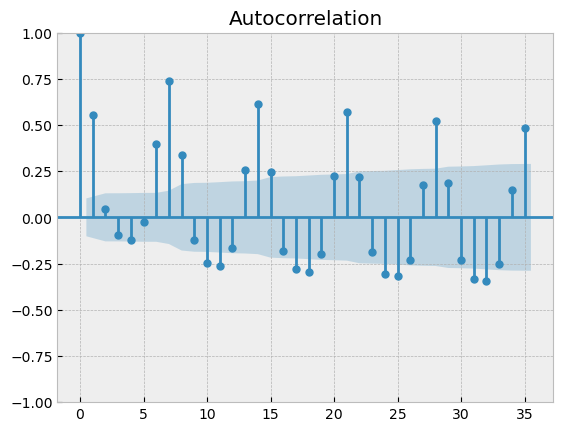

In [4]:
statsmodels.graphics.tsaplots.plot_acf(train_data['Load'],lags=35);
plt.show();

c:\ProgramData\Anaconda3\envs\text_mining\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


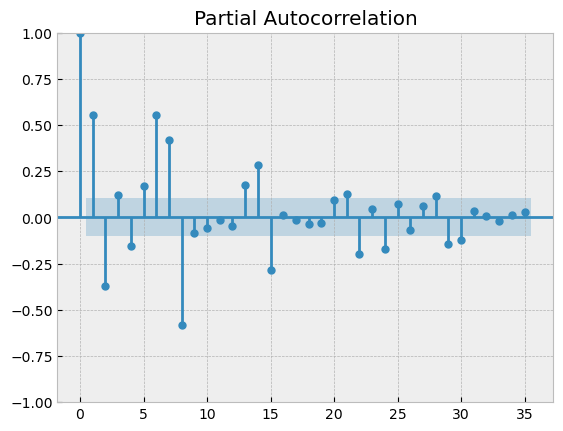

In [5]:
statsmodels.graphics.tsaplots.plot_pacf(train_data['Load'],lags=35);
plt.show();

In ACF vs PACF plots, we see that the function shuts off in PACF case, suggesting an AR of order 2, with the possibility of taking into account the weekly effect (as we have seen in the first report)

# 2. Modeling (training)

By looking at the analysis above, I decided (after different tests) to model the series for short-term purpose using an autoregressive effect of order 2 (i.e. the value is affected by the values of 2 days before) together with a moving average of order 1 (i.e. a random effect of the previous day) and 2 weekly effect (i.e. the value is also affected by the values of the 7th day and 14th day before).

In [6]:
model = sm.tsa.statespace.SARIMAX(train_data,
                                  order=(2,0,1),
                                  seasonal_order=(2,0,1,7),                                 
                                  freq='D')

# fit the model to the data
results = model.fit()

c:\ProgramData\Anaconda3\envs\text_mining\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\ProgramData\Anaconda3\envs\text_mining\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\ProgramData\Anaconda3\envs\text_mining\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [7]:
print(results.summary())

                                     SARIMAX Results                                     
Dep. Variable:                              Load   No. Observations:                  365
Model:             SARIMAX(2, 0, 1)x(2, 0, 1, 7)   Log Likelihood               -4585.357
Date:                           Fri, 03 Mar 2023   AIC                           9184.714
Time:                                   13:18:21   BIC                           9212.014
Sample:                               01-01-2018   HQIC                          9195.563
                                    - 12-31-2018                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4407      1.974      0.223      0.823      -3.428       4.310
ar.L2          0.4221      1.820      0.232

Now we see in the same way of the challenge 2 how the model performs with training data, just for the sake of completeness: (excluding the first values for which we can't fit the model)

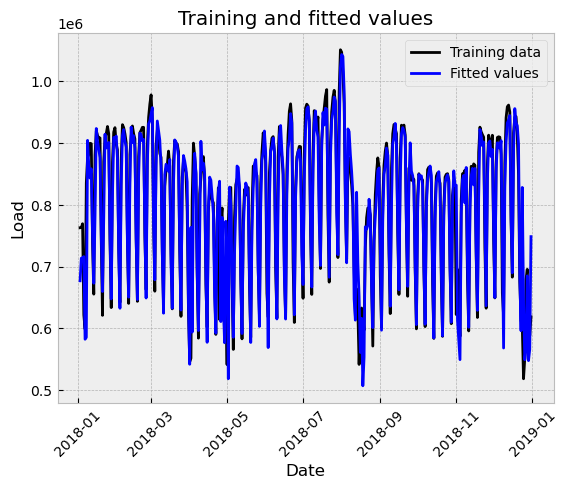

In [8]:
plt.plot(train_data[2:], color = "black",label = 'Training data')
plt.plot(results.fittedvalues[2:], color='blue', label = 'Fitted values')
plt.ylabel('Load')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Training and fitted values")
plt.legend()
plt.show()

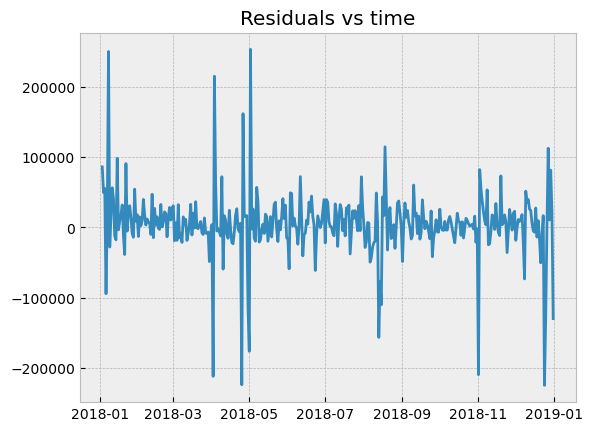

In [9]:
plt.plot(results.resid[2:])
plt.title('Residuals vs time')
plt.show()

As before, we can accept the model expecially because we want it to be good in forecasting:

# 3. Test and evaluation

Since this model is short-term oriented, we want look at how it performs on the whole test year (2019), while instead we take only the first 3 weeks of 2019. 

To be precise, 21 days of forecasting is a quite high value since the model needs values from 14 days before, so the last week will be based only on predicted values.

In real-cases, the model should be evaluated on 14 days and then use the new OBSERVED values for new forecasts. But a longer prediction here is useful to obtain a more complete analysis.

In [10]:
#forecast
preds = results.forecast(steps=21)

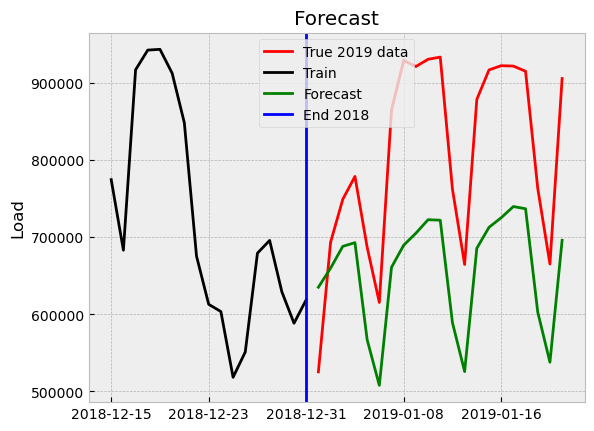

In [11]:
plt.plot(test_data[0:len(preds)], color = "red",label = 'True 2019 data')
plt.plot(train_data.loc['2018-12-15':'2018-12-31'], color = "black", label = 'Train')
plt.plot(preds, color='green', label = 'Forecast')
plt.axvline(pd.Timestamp('2018-12-31'),color='blue', label='End 2018')
ax=plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(8))
plt.ylabel('Load')
plt.title("Forecast")
plt.legend(loc='upper center')
plt.show()

As we see from the plot, the model, in forecasting, is very good in initial phase. Then, the predicted values get increasingly divergent from the observed ones.

As last part, evaluate the model numerically with absolute and relative RMSE.

We will notice a RMSE higher than the one in long-term model case; this is, of course, affected by the fact that we are asking the model to predict using also forecast. Considering only 2 weeks instead of 3, the RMSE is reduced by 1%, so it is not a very big advantage. 

In [12]:
day_rmse = mean_squared_error(test_data[0:len(preds)].Load.values,
                          preds,squared = False)


print(day_rmse)

print('relative measure of rmse w.r.t range:')
print(day_rmse/(np.max(data.Load.values)-np.min(data.Load.values)))

169082.07092695788
relative measure of rmse w.r.t range:
0.23168206719204146
